In [ ]:
import time

import catboost as cb
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from deep_translator import GoogleTranslator
from langdetect import detect_langs
from tqdm import tqdm

In [ ]:
data = pd.read_csv("./data/train_issues.csv")
data_sub = pd.read_csv("./data/test_issues.csv")
data_coms = pd.read_csv("./data/train_comments.csv")
data_sub_coms = pd.read_csv("./data/test_comments.csv")

data_emp = pd.read_csv("./data/employees.csv")

# Перевод текстов на английский

Перевод производится через бесплатную библиотеку deep-learn запросами к гугл апи(бесплатно, но с ограничениями по лимиту). 
Такая процедура позволяет получить текст на 1 языке и исправить ошибки в словах для последующего анализа текста.

### Перевод summary

In [ ]:
data["summary"]

0                     UI тесты по заказу "Добро КейДжи"
1                            UI тесты раздела "Профиль"
2                        UI тесты раздела "Личный счет"
3                            UI тесты раздела "Новости"
4               UI тесты раздела "Зоны скидок и доплат"
                             ...                       
9584    Make a test to check teachers pages for VN & TH
9585     Set up the neo4j by using a dataset from Slack
9586          Set up a graph in neo4j by GitLab dataset
9587               Parse a dataset from teacherly slack
9588    Expand a gitlab parser by adding members emails
Name: summary, Length: 9589, dtype: object

In [ ]:
res = []
n = 0
for i in tqdm(range(len(data["summary"]))):
    det = detect_langs(data["summary"][i])
    if det[0].lang == "en" and det[0].prob > 0.96:
        res.append(data["summary"][i])
        continue

    if (n + 1) % 100 == 0:
        time.sleep(65)
    translated = GoogleTranslator(source='auto', target='en').translate(text=data["summary"][i])
    res.append(translated)
    n = n + 1


In [ ]:
data["summary"] = res

In [ ]:
data.to_csv("./data/train_issues_en.csv", sep=",", index=False)

In [ ]:
res = []
n = 0
for i in tqdm(range(len(data_sub["summary"]))):
    det = detect_langs(data_sub["summary"][i])
    if det[0].lang == "en" and det[0].prob > 0.96:
        res.append(data_sub["summary"][i])
        continue

    if (n + 1) % 100 == 0:
        time.sleep(65)
    translated = GoogleTranslator(source='auto', target='en').translate(text=data_sub["summary"][i])
    res.append(translated)
    n = n + 1


100%|██████████| 1070/1070 [05:10<00:00,  3.45it/s] 


In [ ]:
data_sub["summary"] = res

In [ ]:
data_sub.to_csv("./data/test_issues_en.csv", sep=",", index=False)

# Загрузка переведенных текстов

In [ ]:
data = pd.read_csv("./data/train_issues_en.csv")
data_sub = pd.read_csv("./data/test_issues_en.csv")

# Feature engeneering

## Распределение таргета

In [ ]:
data.isnull().value_counts()

id     created  key    summary  project_id  assignee_id  creator_id  overall_worklogs
False  False    False  False    False       False        False       False               9589
dtype: int64

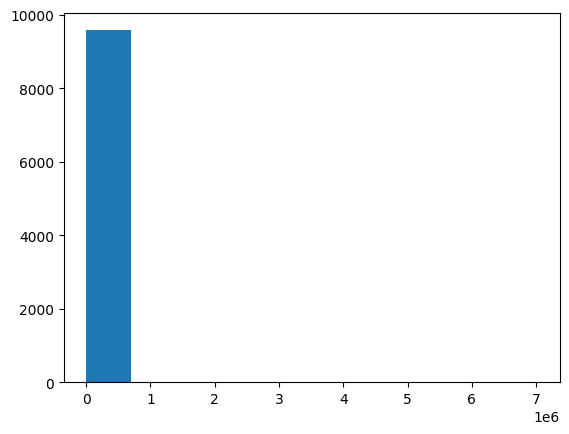

In [ ]:
plt.hist(data["overall_worklogs"])
pass

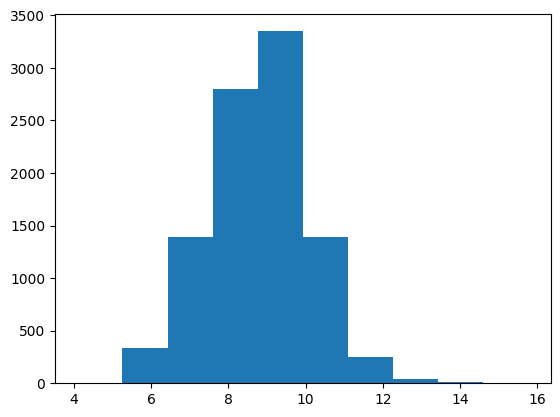

In [ ]:
plt.hist(np.log(data["overall_worklogs"]))
pass

## Данные по сотрудникам

In [ ]:
data_emp.columns

Index(['id', 'active', 'full_name', 'position', 'hiring_type', 'payment_type',
       'salary_calculation_type', 'english_level', 'passport', 'is_nda_signed',
       'is_labor_contract_signed', 'is_added_to_internal_chats',
       'is_added_one_to_one'],
      dtype='object')

In [ ]:
data_emp = data_emp.drop(['full_name', 'position', 'hiring_type', 'payment_type',
                          'salary_calculation_type', 'english_level', "is_added_to_internal_chats", "is_nda_signed"],
                         axis=1)

In [ ]:
data = pd.merge(data, data_emp, left_on="assignee_id", right_on="id", how='inner').drop(["id_y"], axis=1)
data["id"] = data["id_x"]
data_sub = pd.merge(data_sub, data_emp, left_on="assignee_id", right_on="id", how='inner').drop(["id_y"], axis=1)
data_sub["id"] = data_sub["id_x"]

## следующее упоминание

In [ ]:
data["created"] = pd.to_datetime(data["created"])
data_sub["created"] = pd.to_datetime(data_sub["created"])

In [ ]:
def next_time(data):
    next_time_as = []
    next_time_cr = []
    for i in tqdm(range(len(data["assignee_id"]))):
        assingn_task = data["assignee_id"].iloc[i]
        date_start = data["created"].iloc[i]
        flag_as = 0
        flag_creat = 0
        for j in range(i + 1, len(data["assignee_id"])):
            if data["creator_id"].iloc[j] == assingn_task:
                if (data["created"].iloc[j] - date_start) / np.timedelta64(1, 's') < 500:
                    continue
                next_time_cr.append((data["created"].iloc[j] - date_start) / np.timedelta64(1, 's'))
                flag_creat = 1
                break
        if flag_creat != 1:
            next_time_cr.append(0.00000000000000000000001)
        for j in range(i + 1, len(data["assignee_id"])):
            if data["assignee_id"].iloc[j] == assingn_task:
                if (data["created"].iloc[j] - date_start) / np.timedelta64(1, 's') < 500:
                    continue
                next_time_as.append((data["created"].iloc[j] - date_start) / np.timedelta64(1, 's'))
                flag_as = 1
                break
        if flag_as != 1:
            next_time_as.append(0.00000000000000000000001)
    data["next_time_as"] = np.log(next_time_as)
    data["next_time_cr"] = np.log(next_time_cr)
    return data

In [ ]:
data = next_time(data)
data_sub = next_time(data_sub)

100%|██████████| 1070/1070 [00:00<00:00, 1184.17it/s]


## парсинг данных из отчетов

### длина заголовка

In [ ]:
data["len_sum"] = [len(i) for i in data["summary"]]
data_sub["len_sum"] = [len(i) for i in data_sub["summary"]]

### ембединги stackoverflow mnst

In [ ]:
bert_sub = pd.read_csv("./data/stackmnst_sub_25svd.csv")
bert = pd.read_csv("./data/stackmnst_train_25svd.csv")

In [ ]:
data = pd.merge(data, bert, left_on="id", right_on="id", how='inner')

In [ ]:
data_sub = pd.merge(data_sub, bert_sub, left_on="id", right_on="id", how='inner')

### количество комментов

In [ ]:
np.seterr(divide='ignore')
data["num_of_coms"] = np.log([len(data_coms[data_coms["issue_id"] == i]) for i in data["id"]])
data_sub["num_of_coms"] = np.log([len(data_sub_coms[data_sub_coms["issue_id"] == i]) for i in data_sub["id"]])
np.seterr(divide='warn')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [ ]:
data["num_of_coms"].replace([np.inf, -np.inf], -2, inplace=True)
data_sub["num_of_coms"].replace([np.inf, -np.inf], -2, inplace=True)

### средняя длина комментов

In [ ]:
data_coms["len"] = [len(i) for i in data_coms["text"]]
data["avarage_len_of_com"] = np.log([np.mean(data_coms[data_coms["issue_id"] == i]["len"]) for i in data["id"]])

data_sub_coms["len"] = [len(i) for i in data_sub_coms["text"]]
data_sub["avarage_len_of_com"] = np.log(
    [np.mean(data_sub_coms[data_sub_coms["issue_id"] == i]["len"]) for i in data_sub["id"]])

### заполнение пропусков

In [ ]:
data = data.fillna(-1000)
data_sub = data_sub.fillna(-1000)

### комбинации категориальных признаков

In [ ]:
data["project_id=assignee_id"] = data["project_id"].astype("str") + "-" + data["assignee_id"].astype("str")
data["creator_id=assignee_id"] = data["creator_id"].astype("str") + "-" + data["assignee_id"].astype("str")
data["project_id=creator_id"] = data["project_id"].astype("str") + "-" + data["creator_id"].astype("str")
data["creator_id=assignee_id - project_id"] = data["project_id"].astype("str") + "-" + data["creator_id"].astype(
    "str") + "-" + data["assignee_id"].astype("str")

data_sub["project_id=assignee_id"] = data_sub["project_id"].astype("str") + "-" + data_sub["assignee_id"].astype("str")
data_sub["creator_id=assignee_id"] = data_sub["creator_id"].astype("str") + "-" + data_sub["assignee_id"].astype("str")
data_sub["project_id=creator_id"] = data_sub["project_id"].astype("str") + "-" + data_sub["creator_id"].astype("str")
data_sub["creator_id=assignee_id - project_id"] = data_sub["project_id"].astype("str") + "-" + data_sub[
    "creator_id"].astype("str") + "-" + data_sub["assignee_id"].astype("str")

## средние для категориальных переменных(для кросс валидации)

In [ ]:
def smooth_mean_by_cat(data_train, data_test, target, categories, alpha=10):
    for i in categories:
        uniq = np.unique(data_train[i])
        mean = np.mean(data_train[target])
        dict_i = {}
        for j in uniq:
            smooth_mean_j = (np.mean(data_train[data_train[i] == j][target]) * len(
                data_train[data_train[i] == j][target]) + alpha * mean) / (
                                        len(data_train[data_train[i] == j][target]) + alpha)
            dict_i[j] = smooth_mean_j
        data_train[i + "_smooth_mean"] = data[i].map(dict_i)
        data_test[i + "_smooth_mean"] = data_test[i].map(dict_i)

    return data_train, data_test

# Обучение моделей

## Кроссвалидация

### генерация фолдов

In [ ]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=2)

folds = []
for train, test in kfold.split(data):
    folds.append([data.iloc[train], data.iloc[test]])

In [ ]:
data.columns

Index(['id_x', 'created', 'key', 'summary', 'project_id', 'assignee_id',
       'creator_id', 'overall_worklogs', 'active', 'passport',
       'is_labor_contract_signed', 'is_added_one_to_one', 'id', 'next_time_as',
       'next_time_cr', 'len_sum', 'Unnamed: 0', 'bert-0', 'bert-1', 'bert-2',
       'bert-3', 'bert-4', 'bert-5', 'bert-6', 'bert-7', 'bert-8', 'bert-9',
       'bert-10', 'bert-11', 'bert-12', 'bert-13', 'bert-14', 'bert-15',
       'bert-16', 'bert-17', 'bert-18', 'bert-19', 'bert-20', 'bert-21',
       'bert-22', 'bert-23', 'bert-24', 'num_of_coms', 'avarage_len_of_com',
       'project_id=assignee_id', 'creator_id=assignee_id',
       'project_id=creator_id', 'creator_id=assignee_id - project_id'],
      dtype='object')

In [ ]:
cat_features = ['project_id', 'assignee_id',
                'creator_id', 'passport',
                'is_added_one_to_one', 'project_id=assignee_id',
                'creator_id=assignee_id', 'project_id=creator_id',
                'creator_id=assignee_id - project_id']
target = "overall_worklogs"
for i in range(len(folds)):
    folds[i][0], folds[i][1] = smooth_mean_by_cat(folds[i][0], folds[i][1], target, cat_features)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


def metric_folds_model(model, folds, target, features, last_fold=False):
    from matplotlib.pyplot import figure
    r2 = []
    mse = []
    mae = []
    res = pd.DataFrame()

    for i in tqdm(range(len(folds))):
        if last_fold and i != 4:
            continue

        folds[i][0] = folds[i][0][(folds[i][0][target] < 300000) & (folds[i][0][target] > 300)]
        folds[i][1] = folds[i][1][(folds[i][1][target] < 300000) & (folds[i][1][target] > 300)].copy()
        model.fit(folds[i][0][features], folds[i][0][target], eval_set=(folds[i][1][features], folds[i][1][target]),
                  plot=True)
        pred = model.predict(folds[i][1][features])
        pred = np.round(pred)
        real = folds[i][1][target]
        r2.append(r2_score(real, pred))
        mae.append(mean_absolute_error(real, pred))
        mse.append(mean_squared_error(real, pred) ** 0.5)
        figure(figsize=(16, 16), dpi=80)
        plt.plot(np.array(real))
        plt.plot(np.array(pred))
        plt.show()
    r2.append(np.mean(r2))
    mae.append(np.mean(mae))
    mse.append(np.mean(mse))
    res["root Mean Squared Error"] = mse
    res["Mean Error"] = mae
    res["R2 error"] = r2

    return res


In [ ]:
folds[0][0].columns

Index(['id_x', 'created', 'key', 'summary', 'project_id', 'assignee_id',
       'creator_id', 'overall_worklogs', 'active', 'passport',
       'is_labor_contract_signed', 'is_added_one_to_one', 'id', 'next_time_as',
       'next_time_cr', 'len_sum', 'Unnamed: 0', 'bert-0', 'bert-1', 'bert-2',
       'bert-3', 'bert-4', 'bert-5', 'bert-6', 'bert-7', 'bert-8', 'bert-9',
       'bert-10', 'bert-11', 'bert-12', 'bert-13', 'bert-14', 'bert-15',
       'bert-16', 'bert-17', 'bert-18', 'bert-19', 'bert-20', 'bert-21',
       'bert-22', 'bert-23', 'bert-24', 'num_of_coms', 'avarage_len_of_com',
       'project_id=assignee_id', 'creator_id=assignee_id',
       'project_id=creator_id', 'creator_id=assignee_id - project_id',
       'project_id_smooth_mean', 'assignee_id_smooth_mean',
       'creator_id_smooth_mean', 'passport_smooth_mean',
       'is_added_one_to_one_smooth_mean', 'project_id=assignee_id_smooth_mean',
       'creator_id=assignee_id_smooth_mean',
       'project_id=creator_id_smoo

In [ ]:
features = ['project_id', 'assignee_id',
            'creator_id', 'active', 'passport',
            'is_labor_contract_signed', 'is_added_one_to_one', 'id', 'next_time_as',
            'next_time_cr', 'len_sum', 'num_of_coms',
            'avarage_len_of_com', 'project_id_smooth_mean', 'assignee_id_smooth_mean', 'creator_id_smooth_mean',
            'passport_smooth_mean',
            'is_added_one_to_one_smooth_mean', 'bert-0', 'bert-1', 'bert-2', 'bert-3', 'bert-4',
            'bert-5', 'bert-6', 'bert-7', 'bert-8', 'bert-9', 'bert-10', 'bert-11',
            'bert-12', 'bert-13', 'bert-14', 'bert-15', 'bert-16', 'bert-17',
            'bert-18', 'bert-19', 'bert-20', 'bert-21', 'bert-22', 'bert-23',
            'bert-24', 'project_id=assignee_id',
            'creator_id=assignee_id', 'project_id=creator_id',
            'creator_id=assignee_id - project_id',
            'project_id=assignee_id_smooth_mean',
            'creator_id=assignee_id_smooth_mean',
            'project_id=creator_id_smooth_mean',
            'creator_id=assignee_id - project_id_smooth_mean']
target = 'overall_worklogs'
cat_features = ['project_id', 'assignee_id',
                'creator_id', 'passport',
                'is_added_one_to_one', 'project_id=assignee_id',
                'creator_id=assignee_id', 'project_id=creator_id',
                'creator_id=assignee_id - project_id']

## обучение модели

In [ ]:
model_cb = cb.CatBoostRegressor(iterations=2000,
                                random_seed=314, max_depth=10,
                                loss_function="RMSE", early_stopping_rounds=50, cat_features=cat_features,
                                verbose=False, eval_metric="R2")

  0%|          | 0/5 [00:00<?, ?it/s]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

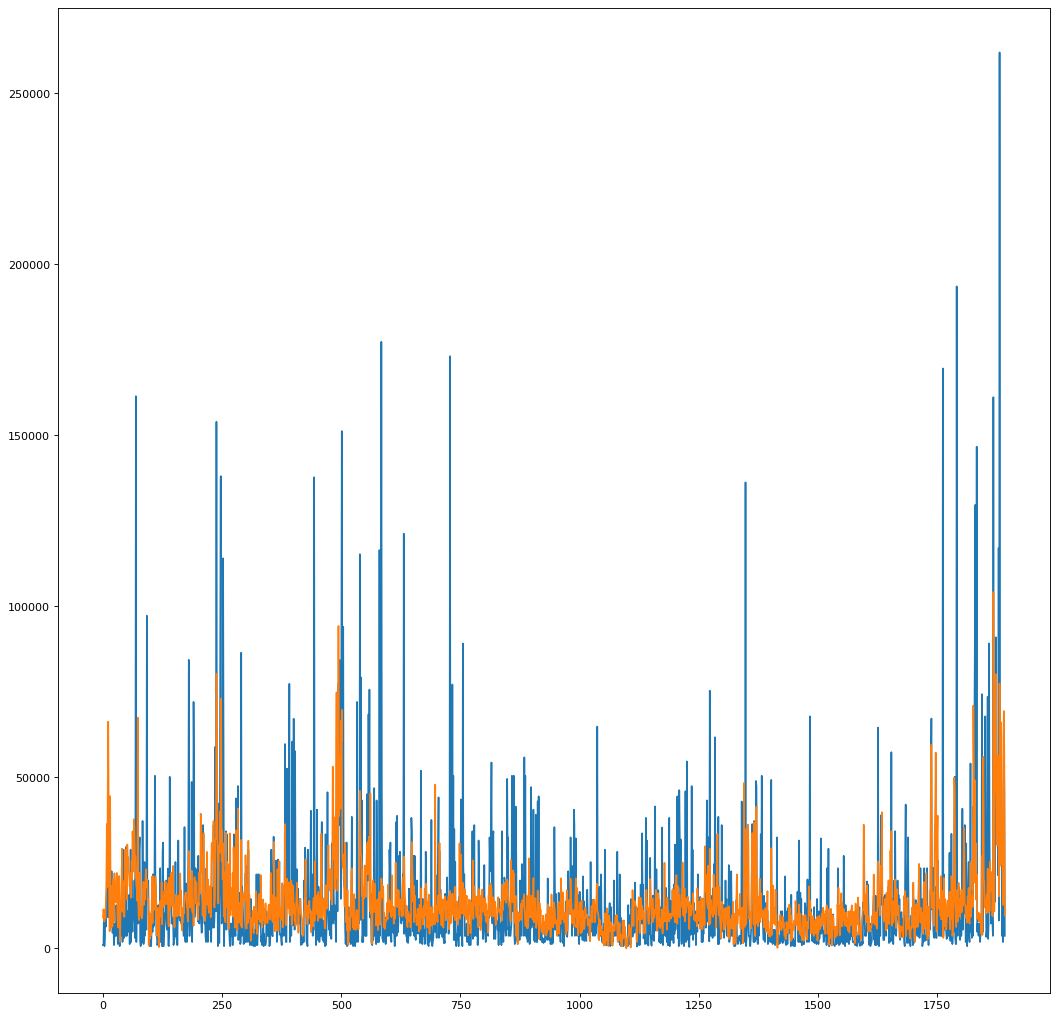

 20%|██        | 1/5 [01:22<05:30, 82.70s/it]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

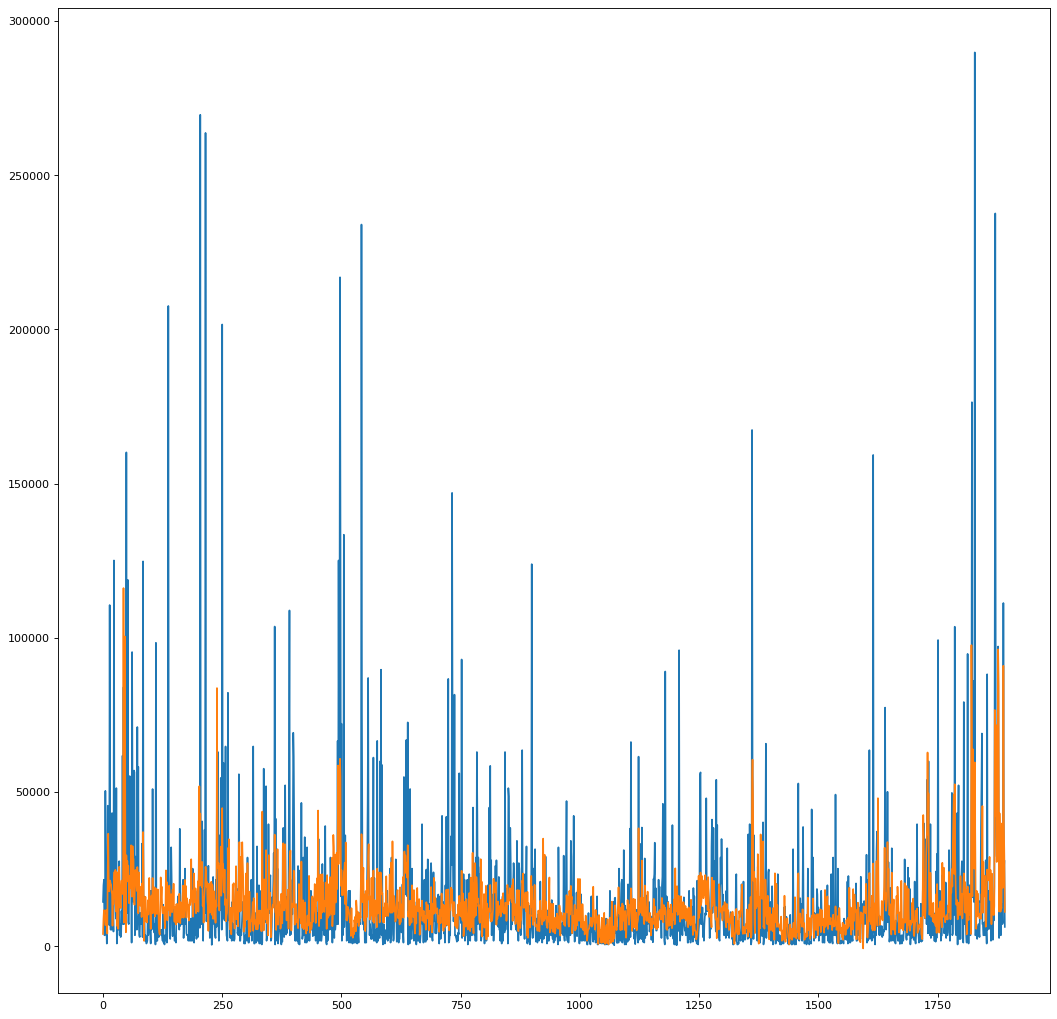

 40%|████      | 2/5 [03:49<06:01, 120.43s/it]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

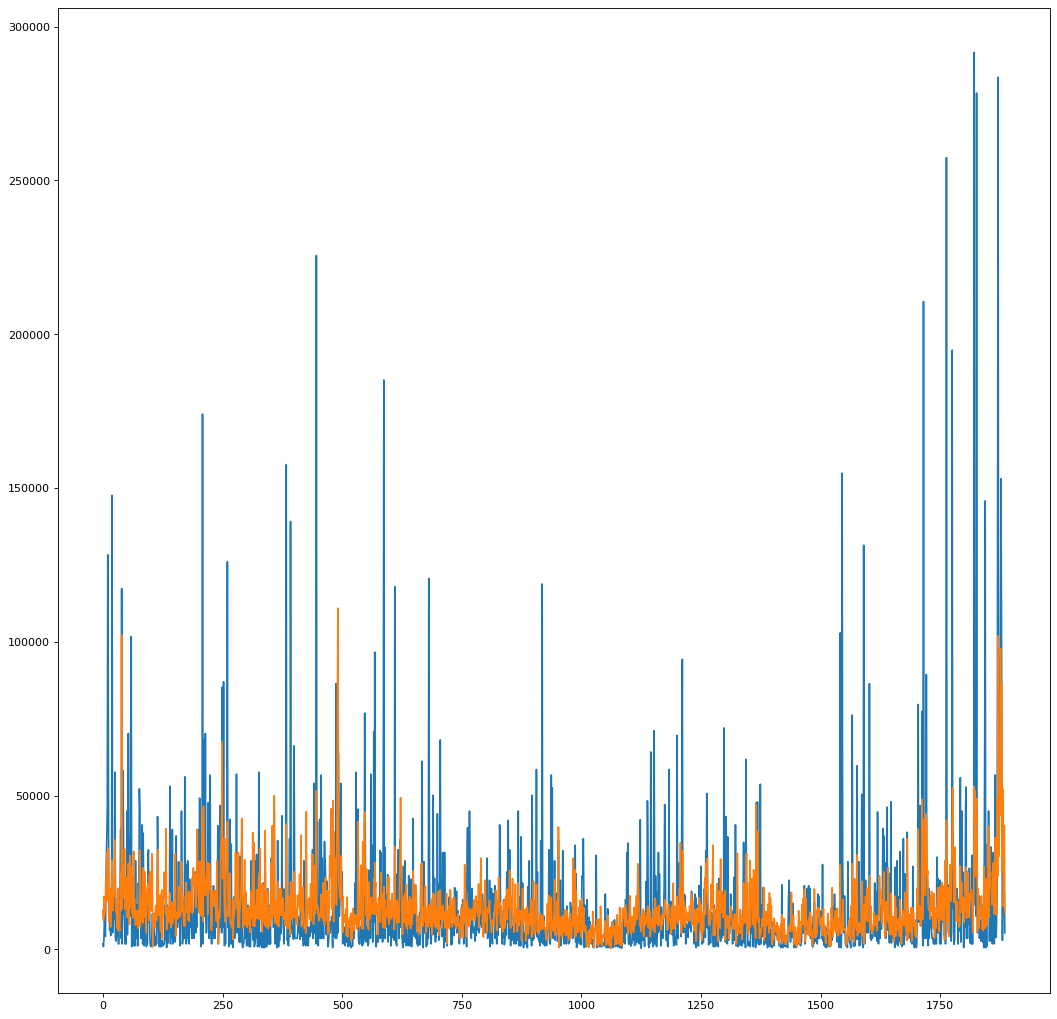

 60%|██████    | 3/5 [05:26<03:39, 109.52s/it]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

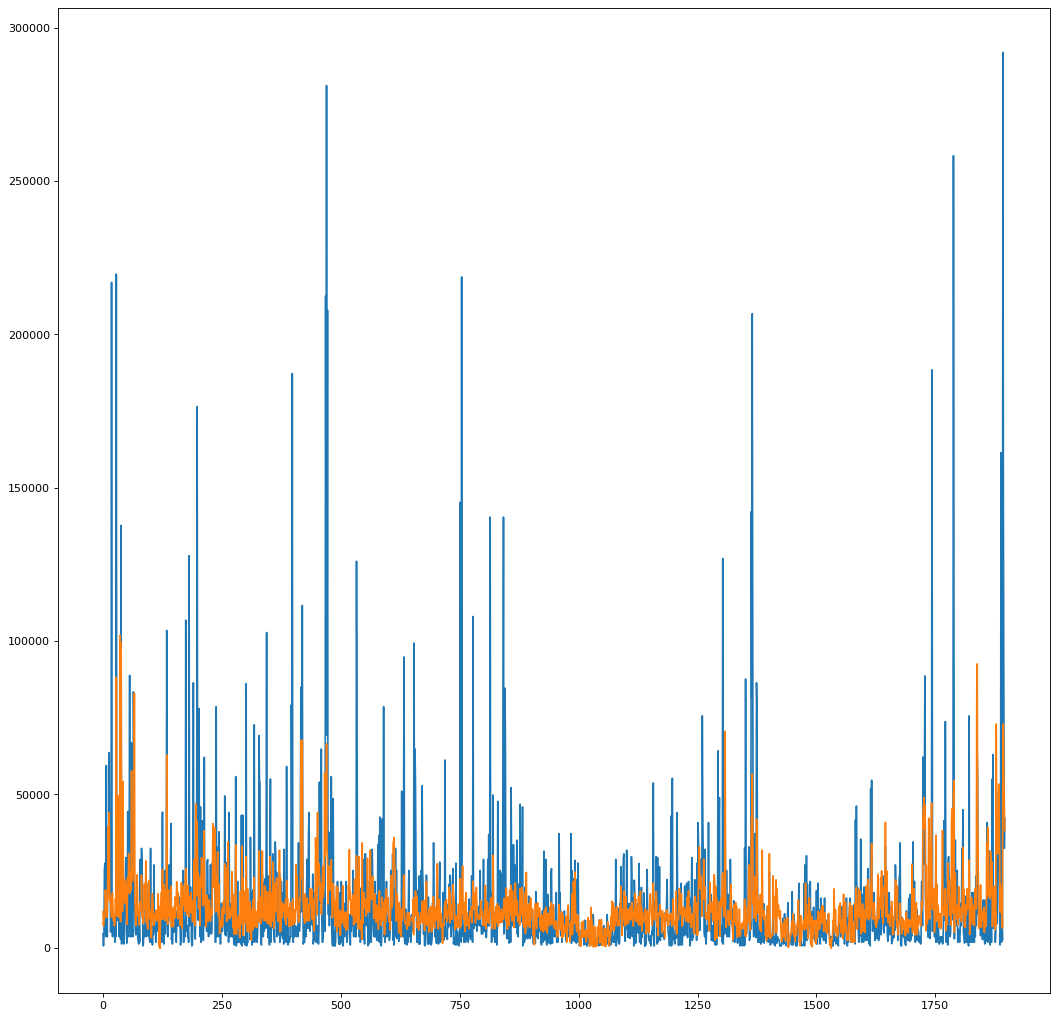

 80%|████████  | 4/5 [06:41<01:36, 96.24s/it] 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

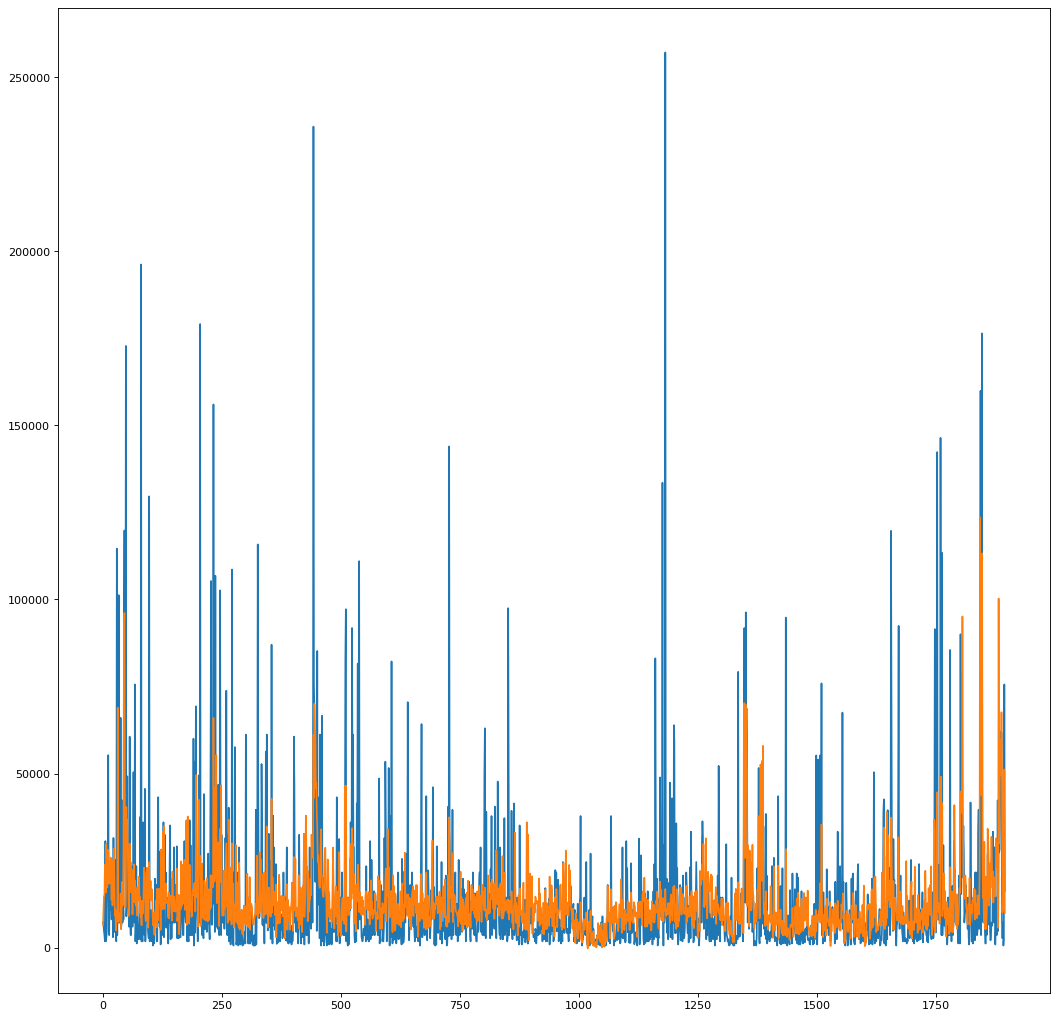

100%|██████████| 5/5 [08:20<00:00, 100.07s/it]


,root Mean Squared Error,Mean Error,R2 error
0,17702.711813,9701.351823,0.222304
1,21063.018625,10658.380021,0.246534
2,20827.232392,10410.849947,0.234056
3,21392.813797,10358.910912,0.242700
4,18520.461799,9813.348285,0.245355
5,19901.247685,10188.568198,0.238190


In [ ]:
metric_folds_model(model_cb, folds, target, features)

### Важность признаков

In [ ]:
data, data_sub = smooth_mean_by_cat(data, data_sub, target, cat_features)

In [ ]:
dicti = {}
for i in range(len(model_cb.get_feature_importance())):
    imput = model_cb.get_feature_importance()[i]
    name = data[features].columns[i]
    dicti[name] = imput
dict(sorted(dicti.items(), key=lambda item: item[1]))

{'is_added_one_to_one_smooth_mean': 0.009348104832073014,
 'passport_smooth_mean': 0.024663970557669425,
 'active': 0.04511254000295896,
 'passport': 0.10928320109706578,
 'is_labor_contract_signed': 0.12542319214773778,
 'is_added_one_to_one': 0.165016342212307,
 'project_id_smooth_mean': 0.19883381011132722,
 'creator_id=assignee_id': 0.34472432882039483,
 'assignee_id_smooth_mean': 0.6031186766762212,
 'project_id': 0.697494067914143,
 'creator_id=assignee_id - project_id': 0.7601520957669097,
 'project_id=assignee_id_smooth_mean': 0.9010281297480462,
 'bert-21': 0.9799943904978042,
 'project_id=creator_id': 1.0413837049666423,
 'bert-0': 1.1398292809515245,
 'bert-18': 1.2683927619255795,
 'bert-23': 1.2965479107434879,
 'bert-7': 1.3783726338259101,
 'bert-20': 1.4210524620673142,
 'bert-10': 1.4662675881028329,
 'assignee_id': 1.5069059205504975,
 'bert-22': 1.5257291533146786,
 'bert-14': 1.5954299367176152,
 'bert-24': 1.5971602832312914,
 'bert-11': 1.6125576004739555,
 'proje

### сабмит

In [ ]:
res = pd.DataFrame()
res["id"] = data_sub["id"]
res["overall_worklogs"] = np.round(model_cb.predict(data_sub[features]), -2)

In [ ]:
np.mean(res.overall_worklogs)

14432.897196261682

In [ ]:
res

,id,overall_worklogs
0,675975,12800.0
1,675972,9300.0
2,675917,6200.0
3,675915,5800.0
4,675912,7700.0
...,...,...
1065,2176348,6900.0
1066,2176673,20600.0
1067,686533,25200.0
1068,686395,8900.0


In [ ]:
res.to_csv("./final.csv", sep=",", index=False)